In [1]:
import icon_tiler
import xarray as xr

## rendering raw tiles

In [19]:
def parse_icon_time(t):
    import numpy as np
    fraction_of_day = t % 1
    daystr = str(int(t))
    return np.datetime64(daystr[0:4] + "-" + daystr[4:6] + "-" + daystr[6:8]) \
         + np.timedelta64(24*60*60, "s") * fraction_of_day

def fix_icon_netcdf(ds):
    ds = ds.assign_coords(time=[parse_icon_time(t) for t in ds.time.values])
    ds = ds.rename({"ncells": "cell"}).squeeze([d for d, s in ds.dims.items() if d.startswith("height") and s == 1])
    return ds

In [24]:
varname = "tas"
itime = -1

data = xr.open_dataset("/work/mh0287/m218027/experiments/Kamikaze2/Kamikaze2_atm_2d_1_ml_20040406T000000Z.nc").pipe(fix_icon_netcdf)
plotvar = data[varname].isel(time=itime)
time = str(data.time.values[itime].astype("datetime64[s]"))

In [25]:
data

<xarray.Dataset>
Dimensions:   (time: 1, cell: 335544320)
Coordinates:
    height    float64 10.0
    height_2  float64 2.0
  * time      (time) datetime64[ns] 2004-04-06
Dimensions without coordinates: cell
Data variables:
    ps        (time, cell) float32 ...
    ts        (time, cell) float32 ...
    clt       (time, cell) float32 ...
    albedo    (time, cell) float32 ...
    pr        (time, cell) float32 ...
    prw       (time, cell) float32 ...
    cllvi     (time, cell) float32 ...
    clivi     (time, cell) float32 ...
    sfcwind   (time, cell) float32 ...
    uas       (time, cell) float32 ...
    vas       (time, cell) float32 ...
    tas       (time, cell) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  37
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          d58d0932-b292-11e8-8f28-c309fbffd099
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               @
    history:              ./icon at 20220614 165753
    references:           see MPIM/DWD publications
    comment:              Daniel Klocke (m218027) on l40589 (Linux 4.18.0-305...

In [26]:
index = xr.open_zarr("indices/tile_cell_indices_R02B11_level_7.zarr/")

In [27]:
#!rm -R rawtiles/l2/sfcwind

In [28]:
import os
outfolder = os.path.join("rawtiles", "l7", varname, time)
os.makedirs(outfolder, exist_ok=True)
icon_tiler.build_raw_tiles(plotvar, index.cell_of_pixel, outfolder)

storing raw tiles
.. level 7
.. level 6
.. level 5
.. level 4
.. level 3
.. level 2
.. level 1
.. level 0


## generating images

In [29]:
tileset = f"l7/{varname}/2004-04-06T00:00:00"

In [30]:
import matplotlib as mpl
norm, cmap = {
    "sfcwind": (mpl.colors.Normalize(vmin=0, vmax=25), mpl.cm.RdYlBu_r),
    "tas": (mpl.colors.Normalize(vmin=260, vmax=310), mpl.cm.turbo),
}[varname]

In [31]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    icon_tiler.build_image_tiles("rawtiles/" + tileset,
                                 "tiles/" + tileset,
                                 norm, cmap, 7)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed | 27.9s
[########################################] | 100% Completed |  1min 51.4s


In [32]:
from IPython.display import Image

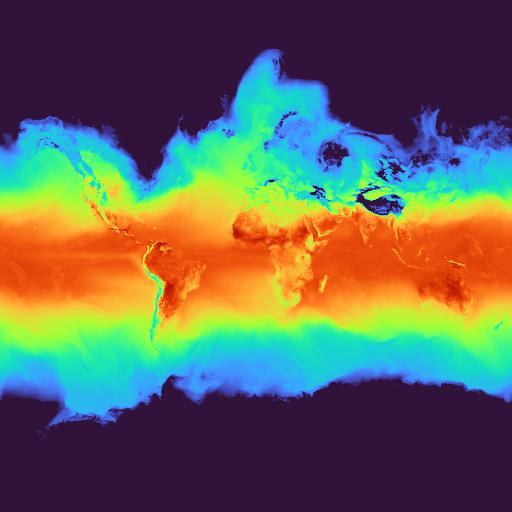

In [33]:
Image(f"tiles/{tileset}/0/0/0.jpg")